In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import re

# Load data:
with pd.ExcelFile("../data/raw/Data AA Graph.xlsx") as xlsx:
    omset_df = pd.read_excel(xlsx, "Omset")
    data_df = pd.read_excel(xlsx, "Data")

In [2]:
# Check data type:
display(omset_df.info())
display(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22224 entries, 0 to 22223
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Thn     22224 non-null  int64  
 1   Bln     22224 non-null  int64  
 2   KdWil   22224 non-null  int64  
 3   KetWil  22224 non-null  object 
 4   KP      22224 non-null  object 
 5   QtyKrt  22224 non-null  float64
 6   Rp      22224 non-null  float64
 7   EC      22224 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14638 entries, 0 to 14637
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Wilayah  14638 non-null  object        
 1   Product  14638 non-null  object        
 2   Unit     8926 non-null   object        
 3   Dimensi  14638 non-null  object        
 4   Periode  14638 non-null  datetime64[ns]
 5   Value    14638 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 686.3+ KB


None

# Assumptions
Current Marketing Spend, Promotional Spend, Percentage etc. Affects the Current Revenue

In [7]:
data_df['Dimensi'].str.title().unique()

array(['Ms Sg Formula', 'Ms Ciptadent', 'Nd Sg Formula', 'Nd Ciptadent',
       'Oos Sg Formula', 'Oos Ciptadent',
       'Advertising Spend (Puluhan Jt Rp)', '% Advertising Spend',
       'Tarps Formula', 'Tarps Ciptadent', 'Brand Awareness',
       'Spontaneous Awareness', 'Ever Used / Trialist', 'Bumo', 'Tom',
       'Recommenders', 'Promotion Spend (Puluhan Jt Rp)',
       '% Promotion Spend', 'Consumer Promo (Puluhan Jt Rp)',
       '% Consumer Promo', 'Trade Promo (Puluhan Jt Rp)', '% Trade Promo',
       'Pasukan Sales Yg Dikerahkan', 'Kunjungan Sales Potensial', 'Ec',
       'Lt', 'Ll Divisi', 'Retail', 'Semi Grosir', 'Ms Teh Gelas',
       'Ms Rio', 'Nd Teh Gelas', 'Nd Rio', 'Oos Teh Gelas', 'Oos Rio',
       'Advertising Spend (Jt Rp)', 'Tarps Teh Gelas', 'Tarps Rio',
       'Tarps Industri', 'Ever Used /Trialist', 'Promotion Spend (Jt Rp)',
       'Consumer Promo (Jt Rp)', 'Trade Promo (Jt Rp)', 'Ms Crystalin',
       'Ms Le Minerale', 'Nd Crystalin', 'Nd Le Minerale',
     

In [19]:
data_df.select_dtypes('object')

,Wilayah,Product,Unit,Dimensi
0,ALL,SG FORMULA,NaN,MS SG Formula
1,ALL,SG FORMULA,NaN,MS SG Formula
2,ALL,SG FORMULA,NaN,MS SG Formula
3,ALL,SG FORMULA,NaN,MS SG Formula
4,ALL,SG FORMULA,NaN,MS SG Formula
...,...,...,...,...
14633,ALL,KIRANTI,Pasukan Sales,Semi Grosir
14634,ALL,KIRANTI,Pasukan Sales,Semi Grosir
14635,ALL,KIRANTI,Pasukan Sales,Semi Grosir
14636,ALL,KIRANTI,Pasukan Sales,Semi Grosir


In [31]:
t = data_df.copy()

# 1. Drop column from `Wilayah`
t = t.drop(columns=['Wilayah'])

# 2. Rename column from `Product` to `KP`
t = t.rename(columns={"Product": "KP"})
t['KP'] = t['KP'].str.upper()

# 3. Normalize string values
for col in t.select_dtypes('object'):
    t[col] = t[col].str.lower()

def change_unit_scale(row):
    if re.match('puluhan jt rp', row['Dimensi']):
        row['Value'] = row['Value'] * 10_000_000
        row['Dimensi'] = re.replace('puluhan jt rp', 'rp', row['Dimensi'])
    elif re.match('jt rp', row['Dimensi']):
        row['Value'] = row['Value'] * 1_000_000
        row['Dimensi'] = re.replace('jt rp', 'rp', row['Dimensi'])
    return row
t = t.apply(change_unit_scale, axis=1)

error: nothing to repeat at position 0

In [30]:
t.Dimensi.unique()

array(['ms sg formula', 'ms ciptadent', 'nd sg formula', 'nd ciptadent',
       'oos sg formula', 'oos ciptadent',
       'advertising spend (puluhan jt rp)', '% advertising spend',
       'tarps formula', 'tarps ciptadent', 'brand awareness',
       'spontaneous awareness', 'ever used / trialist', 'bumo', 'tom',
       'recommenders', 'promotion spend (puluhan jt rp)',
       '% promotion spend', 'consumer promo (puluhan jt rp)',
       '% consumer promo', 'trade promo (puluhan jt rp)', '% trade promo',
       'pasukan sales yg dikerahkan', 'kunjungan sales potensial', 'ec',
       'lt', 'll divisi', 'retail', 'semi grosir', 'ms teh gelas',
       'ms rio', 'nd teh gelas', 'nd rio', 'oos teh gelas', 'oos rio',
       'advertising spend (jt rp)', 'tarps teh gelas', 'tarps rio',
       'tarps industri', 'ever used /trialist', 'promotion spend (jt rp)',
       'consumer promo (jt rp)', 'trade promo (jt rp)', 'ms crystalin',
       'ms le minerale', 'nd crystalin', 'nd le minerale',
     

# Data Preprocessing

In [17]:
from itertools import product

# Constant 
START_DATE = '2015-01-01'
END_DATE = '2024-03-01'

# Preprocess Omset
def preprocess_omset(df):
    # 1. Create `Periode` column (%Y-%m-%d)
    df['Periode'] = pd.to_datetime(df['Thn'].astype(str) + '-' + df['Bln'].astype(str) + '-01')
    df = df.drop(columns=['Thn', 'Bln'])
    df['KP'] = df['KP'].str.upper()

    # 2. Groupby sum aggregation by `Periode` and `KP`
    df = df.groupby(by=['Periode', 'KP']).agg({'QtyKrt': 'sum', 'Rp': 'sum', 'EC': 'sum'}).reset_index()

    # 3. Filter to only use data until 01-03-2024
    df = df[df['Periode']<=END_DATE]

    # 4. Add zeros for missing values between '2015-01-01' and '2024-03-01'
    kp = df['KP'].unique()
    date_ranges = pd.date_range(start=START_DATE, end=END_DATE, freq='MS')

    complete_date_df = pd.DataFrame(product(date_ranges, kp), columns=['Periode', 'KP'])
    df = complete_date_df.merge(df, how='left', on=['Periode', 'KP']).fillna(0)

    return df

cleaned_omset_df = preprocess_omset(omset_df.copy())

# Preprocess Advertising data
advertising_df = data_df.copy()
advertising_df['Dimensi'] = advertising_df['Dimensi'].str.title()
advertising_df = advertising_df[advertising_df['Dimensi'].str.match("Advertising")]

def preprocess_advertising(df):
    # 1. Drop column from `Wilayah`
    df = df.drop(columns=['Wilayah'])

    # 2. Rename column from `Product` to `KP`
    df = df.rename(columns={"Product": "KP"})
    df['KP'] = df['KP'].str.upper()
    
    # 3. Normalize string values
    for col in df.select_dtypes('object'):
        df[col] = df[col].str.lower()

    # 2. Change unit of scale from 'Puluhan Jt Rp' TO 'Jt Rupiah'
    def change_unit_scale(row):
        if re.match(row['Dimensi'], 'Advertising Spend (Puluhan Jt Rp)':
            row['Value'] = row['Value'] * 10_000_000
            row['Dimensi'] = 'Advertising Spend (Rp)'
        elif row['Dimensi'] == 'Advertising Spend (Jt Rp)':
            row['Value'] = row['Value'] * 1_000_000
            row['Dimensi'] = 'Advertising Spend (Rp)'
        return row
    df = df.apply(change_unit_scale, axis=1)
    
    # 3. Filter to only use data until 01-03-2024
    df = df[df['Periode']<=END_DATE]
    return df

cleaned_advertising_df = preprocess_advertising(advertising_df.copy())
cleaned_advertising_df

,KP,Unit,Dimensi,Periode,Value
672,SG FORMULA,IDR,Advertising Spend (Rp),2015-01-01,2.152000e+10
673,SG FORMULA,IDR,Advertising Spend (Rp),2015-02-01,2.211000e+10
674,SG FORMULA,IDR,Advertising Spend (Rp),2015-03-01,1.825000e+10
675,SG FORMULA,IDR,Advertising Spend (Rp),2015-04-01,1.549000e+10
676,SG FORMULA,IDR,Advertising Spend (Rp),2015-05-01,1.533000e+10
...,...,...,...,...,...
12541,KIRANTI,IDR,Advertising Spend (Rp),2023-11-01,2.472261e+08
12542,KIRANTI,IDR,Advertising Spend (Rp),2023-12-01,3.359426e+08
12543,KIRANTI,IDR,Advertising Spend (Rp),2024-01-01,1.408779e+08
12544,KIRANTI,IDR,Advertising Spend (Rp),2024-02-01,1.559157e+08


# Data Verification
Verify Date ranges from January 2015 - March 2024 (111 months)

In [7]:
print("Minimum and Maximum Date")
display(cleaned_omset_df.groupby('KP').agg({'Periode': ['min', 'max']}))
print("Periode (Date) Count")
display(cleaned_omset_df.groupby('KP').agg({'Periode': 'count'}))

Minimum and Maximum Date


Periode           
                     min        max
KP                                 
CRYSTALIN     2015-01-01 2024-03-01
KIRANTI       2015-01-01 2024-03-01
SG FORMULA    2015-01-01 2024-03-01
TANGO WAFER   2015-01-01 2024-03-01
TEH GELAS CUP 2015-01-01 2024-03-01

Periode (Date) Count


,Periode
KP,
CRYSTALIN,111
KIRANTI,111
SG FORMULA,111
TANGO WAFER,111
TEH GELAS CUP,111


In [8]:
print("Minimum and Maximum Date")
display(cleaned_advertising_df.groupby('KP').agg({'Periode': ['min', 'max']}))
print("Periode (Date) Count")
display(cleaned_advertising_df.groupby('KP').agg({'Periode': 'count'}))

Minimum and Maximum Date


Periode           
                     min        max
KP                                 
CRYSTALIN     2015-01-01 2024-03-01
KIRANTI       2015-01-01 2024-03-01
SG FORMULA    2015-01-01 2024-03-01
TANGO WAFER   2015-01-01 2024-03-01
TEH GELAS CUP 2015-01-01 2024-03-01

Periode (Date) Count


,Periode
KP,
CRYSTALIN,111
KIRANTI,111
SG FORMULA,111
TANGO WAFER,111
TEH GELAS CUP,111


# EDA

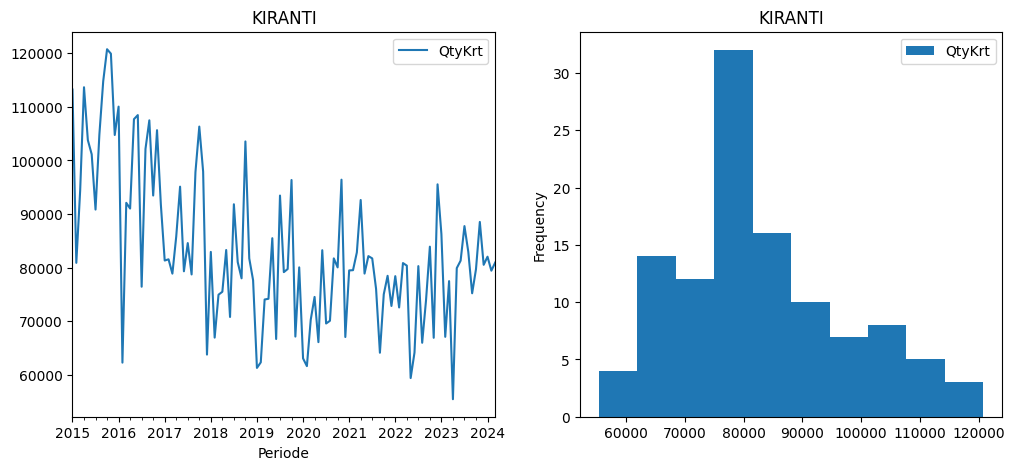

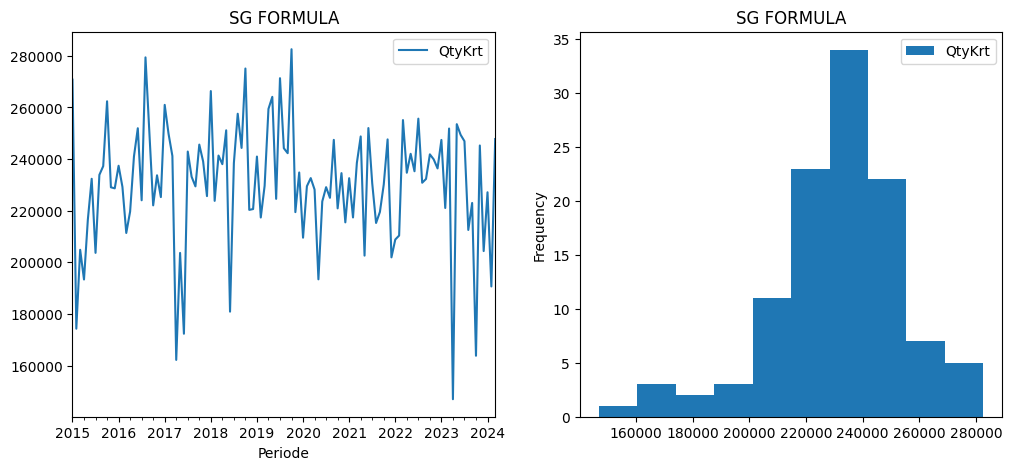

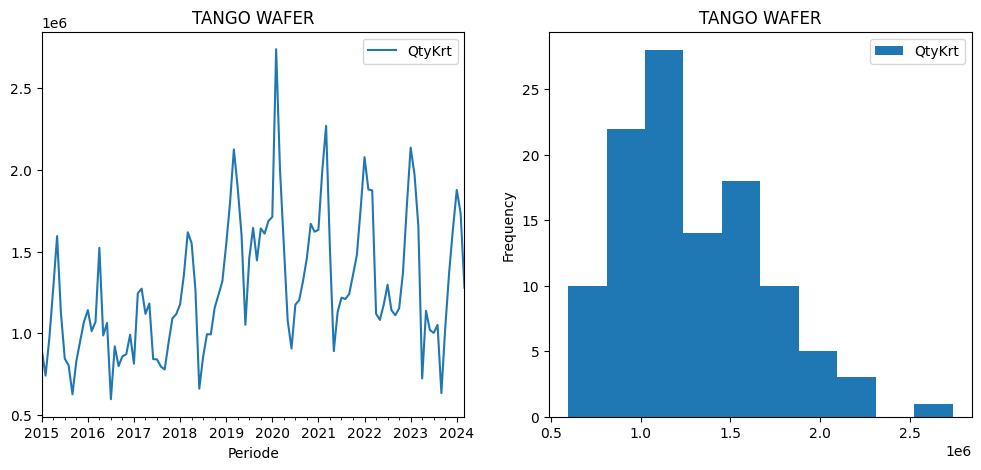

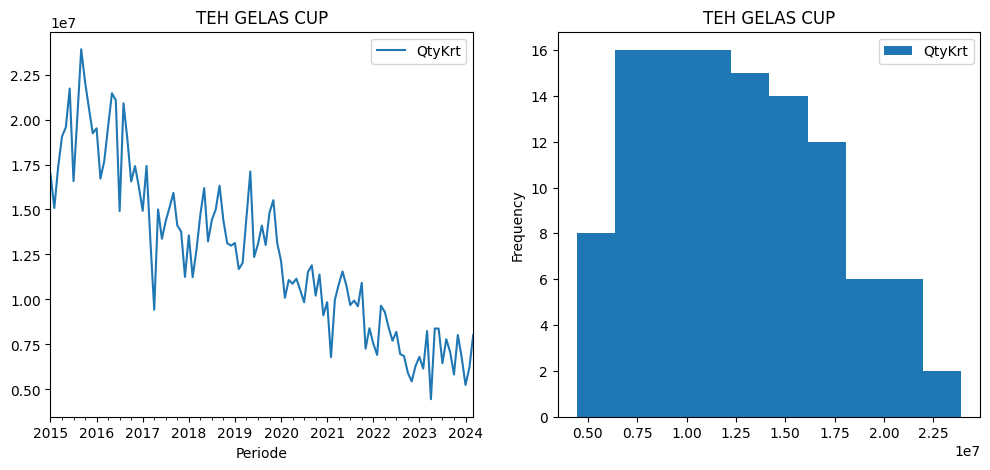

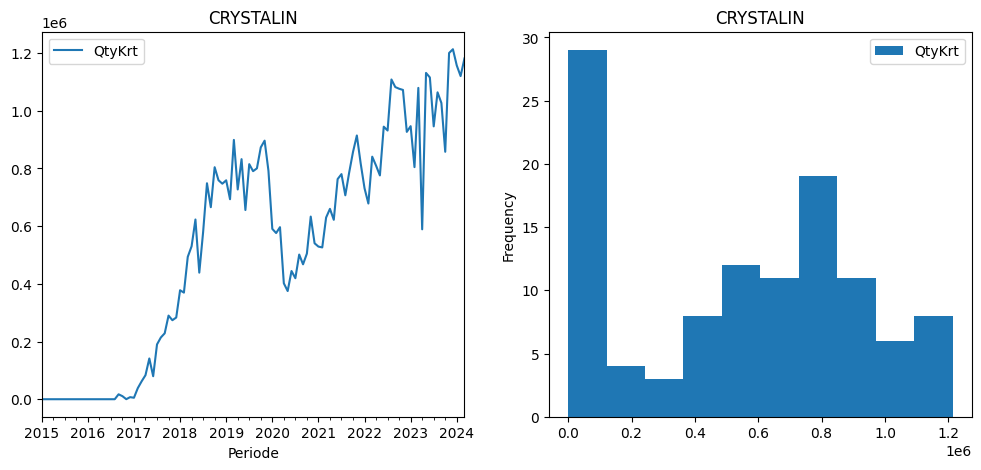

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Line and Distribution Plot
for col in cleaned_omset_df['KP'].unique():
    fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
    filter_ = cleaned_omset_df['KP'] == col
    cleaned_omset_df[filter_].plot(x='Periode', y='QtyKrt', title=col, ax=ax[0])
    cleaned_omset_df[filter_].plot(kind='hist', x='Periode', y='QtyKrt', title=col, ax=ax[1])
    plt.show()

# Advertising Spend and Revenue

NameError: name 'ax2' is not defined

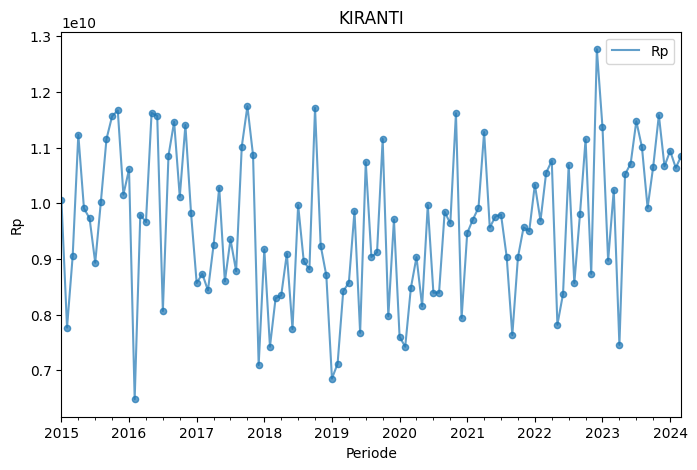

In [10]:
unique_kps = cleaned_omset_df['KP'].unique()

for kp in unique_kps:
    fig, ax1 = plt.subplots(figsize=(8, 5))

    color = 'tab:blue'
    filter_ = cleaned_omset_df['KP'] == kp
    cleaned_omset_df[filter_].plot(x='Periode', y='Rp', color=color, alpha=0.7, title=kp, ax=ax1)
    cleaned_omset_df[filter_].plot(kind='scatter', x='Periode', y='Rp', color=color, alpha=0.7, title=kp, legend=False, ax=ax1)
    ax1.set_xlabel('Periode')
    ax2.set_ylabel('Revenue in Rupiah', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.get_legend().remove()
    ax1.set_ylim(0)

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    color = 'tab:orange'
    filter_ = cleaned_advertising_df['KP'] == kp
    cleaned_advertising_df[filter_].plot(x='Periode', y='Value', color=color, alpha=0.7, ax=ax2)
    cleaned_advertising_df[filter_].plot(kind='scatter', x='Periode', y='Value', color=color, alpha=0.7, legend=False, ax=ax2)
    ax2.set_ylabel('Advertising Spend in Rupiah', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.get_legend().remove()
    ax2.set_ylim(0)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

# Correlation Analysis between Advertising Spend and Revenue

In [11]:
# Assume that current marketing spend affects current revenue
subset_omset_df = cleaned_omset_df[['Periode', 'KP', 'Rp']].rename(columns={'Rp': 'Revenue in Rupiah'})
subset_advertising_df= cleaned_advertising_df[['Periode', 'KP', 'Value']].rename(columns={'Value': 'Ads Spend in Rupiah'})
experiment_df = subset_omset_df.merge(subset_advertising_df, on=['KP', 'Periode'])

In [12]:
kiranti_df = experiment_df.copy()[experiment_df['KP']=='KIRANTI']
sg_formula_df = experiment_df.copy()[experiment_df['KP']=='SG FORMULA']
tango_wafer_df = experiment_df.copy()[experiment_df['KP']=='TANGO WAFER']
teh_gelas_cup_df = experiment_df.copy()[experiment_df['KP']=='TEH GELAS CUP']
crystalin_df = experiment_df.copy()[experiment_df['KP']=='CRYSTALIN']

In [13]:
print("KIRANTI")
display(kiranti_df.drop(columns=['Periode', 'KP']).corr())
print("SG FORMULA")
display(sg_formula_df.drop(columns=['Periode', 'KP']).corr())
print("TANGO WAFER")
display(tango_wafer_df.drop(columns=['Periode', 'KP']).corr())
print("TEH GELAS CUP")
display(teh_gelas_cup_df.drop(columns=['Periode', 'KP']).corr())
print("CRYSTALIN")
display(crystalin_df[crystalin_df['Revenue in Rupiah'] > 0].drop(columns=['Periode', 'KP']).corr())

KIRANTI


,Revenue in Rupiah,Ads Spend in Rupiah
Revenue in Rupiah,1.000000,0.022666
Ads Spend in Rupiah,0.022666,1.000000


SG FORMULA


,Revenue in Rupiah,Ads Spend in Rupiah
Revenue in Rupiah,1.000000,-0.006237
Ads Spend in Rupiah,-0.006237,1.000000


TANGO WAFER


,Revenue in Rupiah,Ads Spend in Rupiah
Revenue in Rupiah,1.00000,0.56389
Ads Spend in Rupiah,0.56389,1.00000


TEH GELAS CUP


,Revenue in Rupiah,Ads Spend in Rupiah
Revenue in Rupiah,1.000000,0.428146
Ads Spend in Rupiah,0.428146,1.000000


CRYSTALIN


,Revenue in Rupiah,Ads Spend in Rupiah
Revenue in Rupiah,1.000000,-0.133393
Ads Spend in Rupiah,-0.133393,1.000000


In [89]:
# Assume that M-1 marketing spend affects current revenue
subset_omset_df = cleaned_omset_df[['Periode', 'KP', 'Rp']].rename(columns={'Rp': 'Revenue in Rupiah'})
subset_advertising_df= cleaned_advertising_df[['Periode', 'KP', 'Value']].rename(columns={'Value': 'Ads Spend in Rupiah'})
experiment_df = subset_omset_df.merge(subset_advertising_df, on=['KP', 'Periode'])

In [90]:
kiranti_df = experiment_df.copy()[experiment_df['KP']=='KIRANTI']
sg_formula_df = experiment_df.copy()[experiment_df['KP']=='SG FORMULA']
tango_wafer_df = experiment_df.copy()[experiment_df['KP']=='TANGO WAFER']
teh_gelas_cup_df = experiment_df.copy()[experiment_df['KP']=='TEH GELAS CUP']
crystalin_df = experiment_df.copy()[experiment_df['KP']=='CRYSTALIN']

In [94]:
kiranti_df['Ads Spend in Rupiah'] = kiranti_df['Ads Spend in Rupiah'].shift(-1)
sg_formula_df['Ads Spend in Rupiah'] = sg_formula_df['Ads Spend in Rupiah'].shift(-1)
tango_wafer_df['Ads Spend in Rupiah'] = tango_wafer_df['Ads Spend in Rupiah'].shift(-1)
teh_gelas_cup_df['Ads Spend in Rupiah'] = teh_gelas_cup_df['Ads Spend in Rupiah'].shift(-1)
crystalin_df['Ads Spend in Rupiah'] = crystalin_df['Ads Spend in Rupiah'].shift(-1)

In [95]:
print("KIRANTI")
display(kiranti_df.drop(columns=['Periode', 'KP']).dropna().corr())
print("SG FORMULA")
display(sg_formula_df.drop(columns=['Periode', 'KP']).dropna().corr())
print("TANGO WAFER")
display(tango_wafer_df.drop(columns=['Periode', 'KP']).dropna().corr())
print("TEH GELAS CUP")
display(teh_gelas_cup_df.drop(columns=['Periode', 'KP']).dropna().corr())
print("CRYSTALIN")
display(crystalin_df[crystalin_df['Revenue in Rupiah'] > 0].drop(columns=['Periode', 'KP']).dropna().corr())

KIRANTI


,Revenue in Rupiah,Ads Spend in Rupiah
Revenue in Rupiah,1.000000,-0.028965
Ads Spend in Rupiah,-0.028965,1.000000


SG FORMULA


,Revenue in Rupiah,Ads Spend in Rupiah
Revenue in Rupiah,1.000000,0.075997
Ads Spend in Rupiah,0.075997,1.000000


TANGO WAFER


,Revenue in Rupiah,Ads Spend in Rupiah
Revenue in Rupiah,1.000000,0.108374
Ads Spend in Rupiah,0.108374,1.000000


TEH GELAS CUP


,Revenue in Rupiah,Ads Spend in Rupiah
Revenue in Rupiah,1.000000,0.408733
Ads Spend in Rupiah,0.408733,1.000000


CRYSTALIN


,Revenue in Rupiah,Ads Spend in Rupiah
Revenue in Rupiah,1.00000,-0.19508
Ads Spend in Rupiah,-0.19508,1.00000


# Forecasting

## Check Seasonality

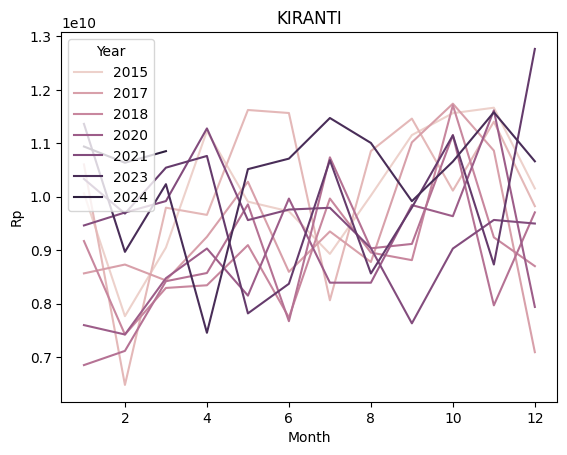

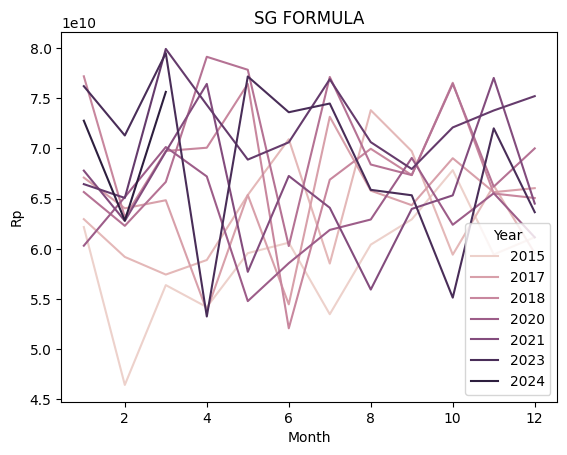

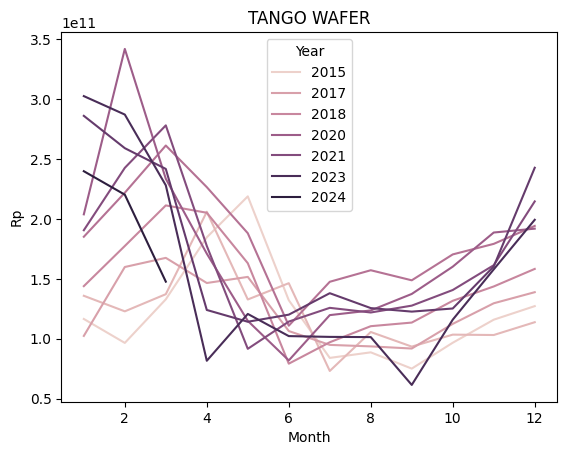

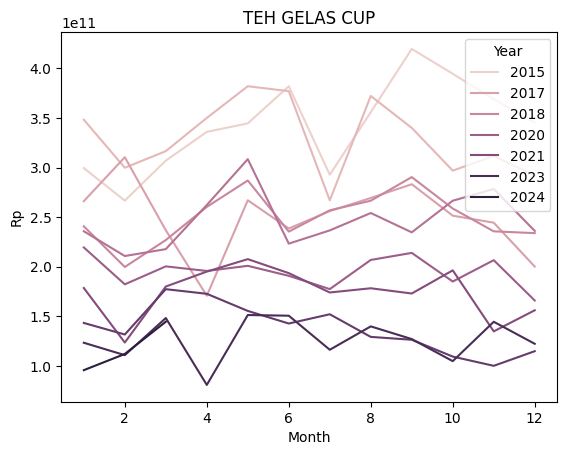

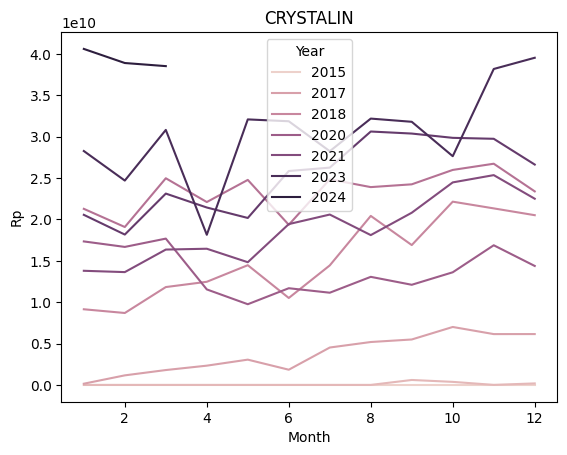

In [47]:
import seaborn as sns

# Line Plot Hue by Year
cleaned_omset_df['Year'] = cleaned_omset_df['Periode'].dt.year
cleaned_omset_df['Month'] = cleaned_omset_df['Periode'].dt.month
for product in cleaned_omset_df['KP'].unique():
    filter_ = cleaned_omset_df['KP']==product
    sns.lineplot(data=cleaned_omset_df[filter_], x='Month', y='Rp', hue='Year')
    plt.title(product)
    plt.show()

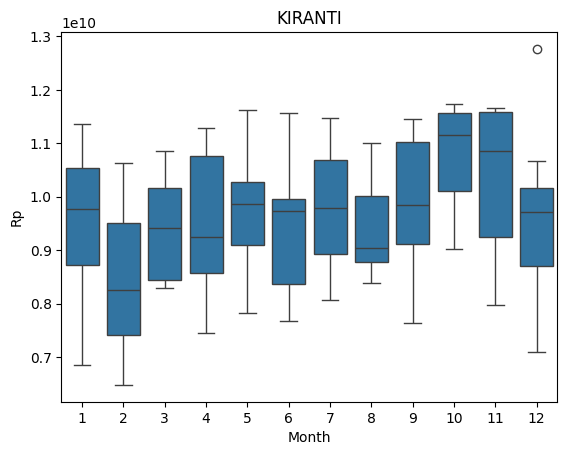

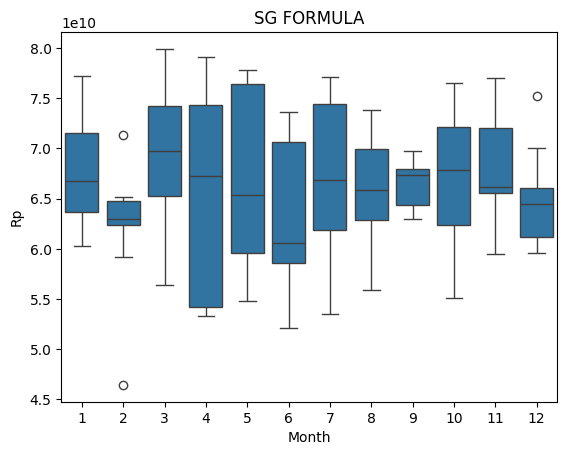

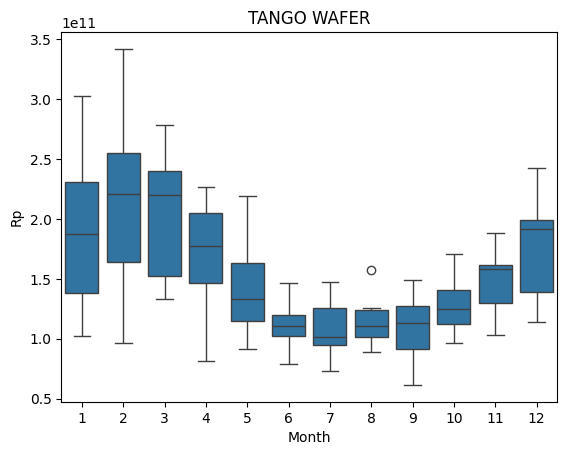

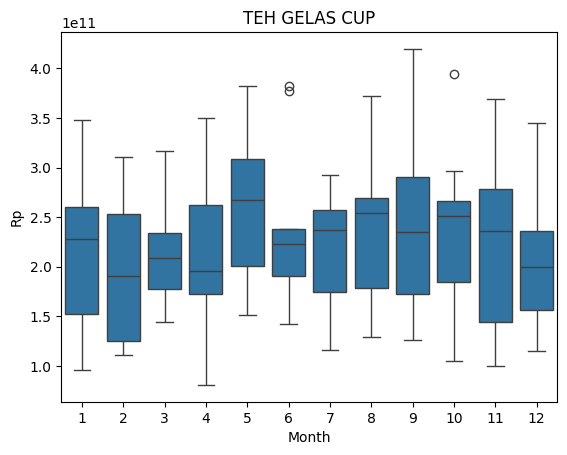

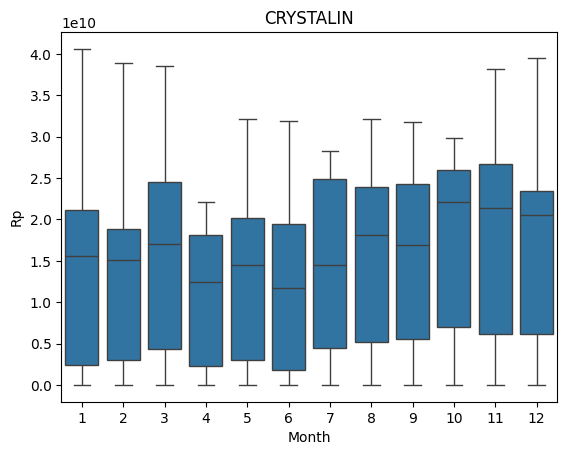

In [48]:
import seaborn as sns

# BoxPlot
cleaned_omset_df['Year'] = cleaned_omset_df['Periode'].dt.year
cleaned_omset_df['Month'] = cleaned_omset_df['Periode'].dt.month
for product in cleaned_omset_df['KP'].unique():
    filter_ = cleaned_omset_df['KP']==product
    sns.boxplot(data=cleaned_omset_df[filter_], x='Month', y='Rp')
    plt.title(product)
    plt.show()

In [33]:
# Seasonality Box Plot
cleaned_omset_df[(cleaned_omset_df['KP']=='KIRANTI') & (cleaned_omset_df['Year']==2016)]

,Periode,KP,QtyKrt,Rp,EC,Year,Month
60,2016-01-01,KIRANTI,110042.291767,1.060580e+10,0.0,2016,1
65,2016-02-01,KIRANTI,62239.291428,6.482176e+09,0.0,2016,2
70,2016-03-01,KIRANTI,92080.000280,9.795813e+09,0.0,2016,3
75,2016-04-01,KIRANTI,91009.874485,9.661431e+09,0.0,2016,4
80,2016-05-01,KIRANTI,107701.708614,1.162267e+10,0.0,2016,5
85,2016-06-01,KIRANTI,108461.416473,1.156621e+10,0.0,2016,6
90,2016-07-01,KIRANTI,76414.417145,8.065017e+09,0.0,2016,7
95,2016-08-01,KIRANTI,102154.291180,1.085435e+10,0.0,2016,8
100,2016-09-01,KIRANTI,107485.332844,1.146141e+10,0.0,2016,9
105,2016-10-01,KIRANTI,93441.333801,1.011504e+10,0.0,2016,10


In [52]:
# Decompose
# Take a look at the PACF and ACF

In [30]:
cleaned_omset_df.Periode.unique()

<DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00',
 ...
 '2023-06-01 00:00:00', '2023-07-01 00:00:00', '2023-08-01 00:00:00',
 '2023-09-01 00:00:00', '2023-10-01 00:00:00', '2023-11-01 00:00:00',
 '2023-12-01 00:00:00', '2024-01-01 00:00:00', '2024-02-01 00:00:00',
 '2024-03-01 00:00:00']
Length: 111, dtype: datetime64[ns]